In [1]:
import pandas as pd
low_memory=False
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import scipy.stats as stats
import joblib
import os

In [6]:

#set datframes for csv imports
crash_people = "Resources/Traffic_Crashes_-_People_20240807.csv"
divvy_trip_history = "Resources/DivvyTripData.csv"

# Set file path for output plots
save_dir="Output Images"


In [7]:

#Read Traffi_Crasjed_-_People_20240007.csv
crash_people=pd.read_csv(crash_people)

#Read DivvyTripData.csv
divvy_trip_history=pd.read_csv(divvy_trip_history)  



In [8]:

# Convert Crash Data dates to date/time format
crash_people['CRASH_DATE'] = pd.to_datetime(crash_people['CRASH_DATE'])

# Remove pre-2020 data
crash_people = crash_people[crash_people['CRASH_DATE'].dt.year > 2019]


In [9]:

# Identify unique CRASH_RECORD_ID values involving Bicycles 
bicycle_crash_ids = crash_people.loc[crash_people['PERSON_TYPE'] == 'BICYCLE']
duplicate_crash_ids = bicycle_crash_ids[bicycle_crash_ids.duplicated(subset='CRASH_RECORD_ID', keep=False)]
bicycle_crash_ids = bicycle_crash_ids.drop_duplicates(subset='CRASH_RECORD_ID', keep='first')

# Group by quarter and count the occurrences
crash_counts_by_quarter = bicycle_crash_ids.resample('Q', on='CRASH_DATE').size()

print(f"There have been {len(bicycle_crash_ids)} reported accidents involving Bicycle's since Q1 of 2020")

There have been 7886 reported accidents involving Bicycle's since Q1 of 2020


In [10]:
# Clean Divvy Date Data
divvy_trip_history['started_at']= pd.to_datetime(divvy_trip_history['started_at'], errors='coerce')
divvy_trip_history['started_at_date'] = divvy_trip_history['started_at'].dt.date

divvy_trip_history['quarter']=divvy_trip_history['started_at'].dt.to_period('Q')

quarterly_rides=divvy_trip_history.groupby('quarter')['ride_id'].count()

print(f"There have been {(divvy_trip_history)['ride_id'].count()} rides taken by Divvy Users since Q1 of 2020")

There have been 23251378 rides taken by Divvy Users since Q1 of 2020


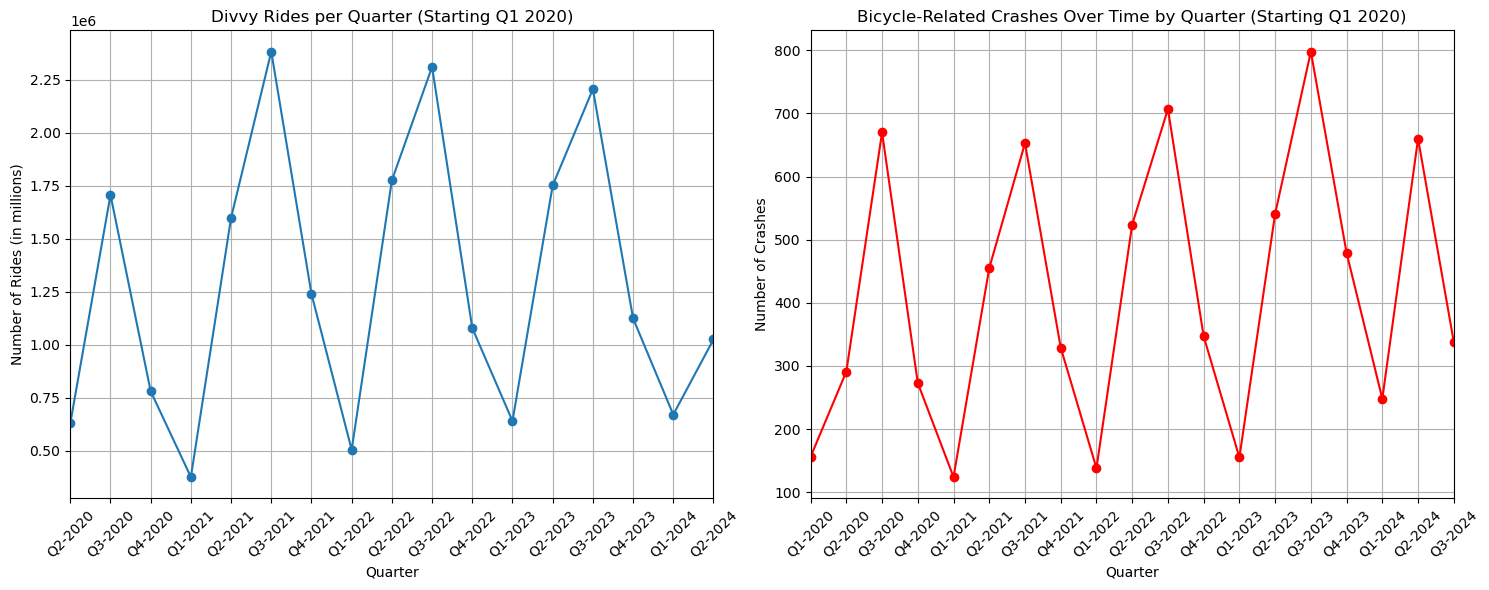

In [12]:

# Create a figure with 2 subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))  # Adjusted figure size for better layout

# First plot (Divvy Rides per Quarter) on ax1
quarterly_rides.plot(ax=ax1, marker='o')
ax1.set_xticks(quarterly_rides.index)
ax1.set_xticklabels(
    [f'Q{q.quarter}-{q.year}' for q in quarterly_rides.index],
    rotation=45
)
ax1.set_title('Divvy Rides per Quarter (Starting Q1 2020)')
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Number of Rides (in millions)')
ax1.grid(True)

# Second plot (Bicycle-Related Crashes) on ax2
crash_counts_by_quarter.plot(ax=ax2, marker='o',color= 'r')
ax2.set_xticks(crash_counts_by_quarter.index)
ax2.set_xticklabels(
    [f'Q{q.quarter}-{q.year}' for q in crash_counts_by_quarter.index],
    rotation=45
)
ax2.set_title('Bicycle-Related Crashes Over Time by Quarter (Starting Q1 2020)')
ax2.set_xlabel('Quarter')
ax2.set_ylabel('Number of Crashes')
ax2.grid(True)

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig(os.path.join(save_dir, "Rides_Crashes_per_Quarter.png"), dpi=300)

# Display the subplots
plt.show()


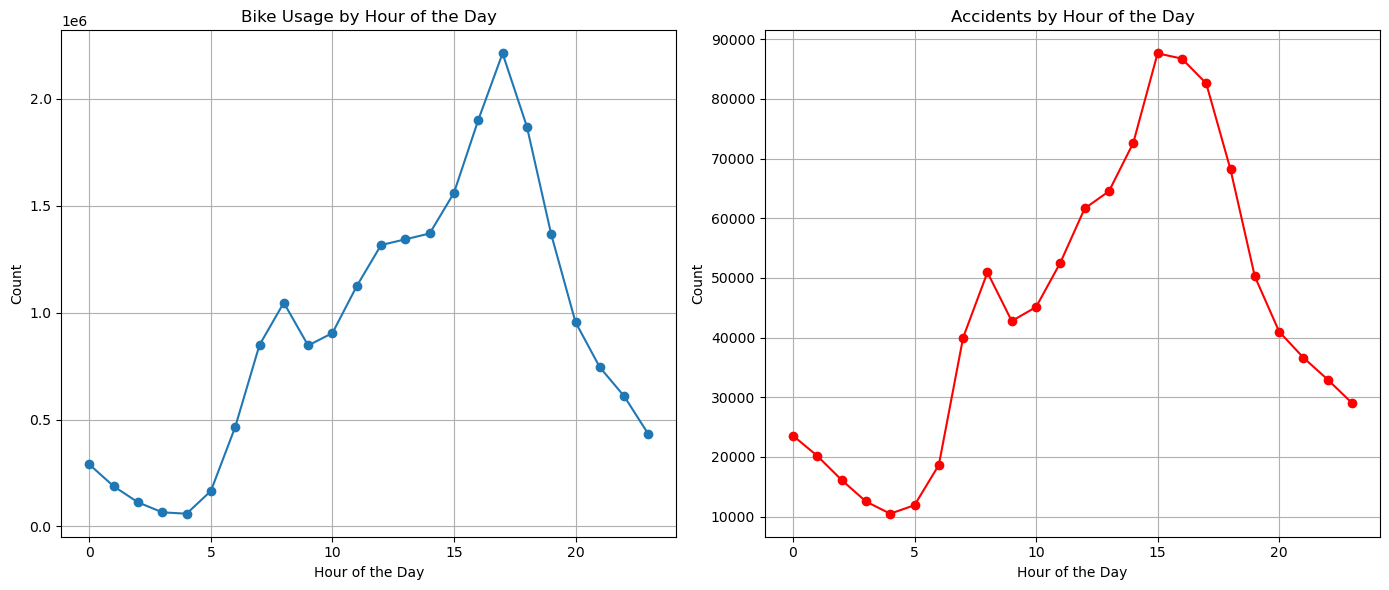

In [13]:
# Are there specific times of day or days of the week where the increase in Divvy bike usage correlates with a higher number of bike accidents or vehicular crashes? 

#Parsing the divvy data to get time data
divvy_trip_history["started_at"] = pd.to_datetime(divvy_trip_history["started_at"], errors='coerce')
divvy_trip_history["ended_at"] = pd.to_datetime(divvy_trip_history["ended_at"], errors='coerce')

#Extracting relevant time of day and day of week info for divvy data
divvy_trip_history['hour'] = divvy_trip_history["started_at"].dt.hour
divvy_trip_history['day_of_week'] = divvy_trip_history["started_at"].dt.day_name()

#Aggregating the usage to determine the size 
usage_by_hour = divvy_trip_history.groupby('hour').size()
usage_by_day = divvy_trip_history.groupby('day_of_week').size()

#Parsing the accident data to get time data
crash_people["date_time"] = pd.to_datetime(crash_people["CRASH_DATE"], format='%m/%d/%Y %I:%M:%S %p')

#Extracting relevant time of day and day of week info for accident data
crash_people['hour'] = crash_people['date_time'].dt.hour
crash_people['day_of_week'] = crash_people['date_time'].dt.day_name()

#Aggregating the usage to determine the size 

accidents_by_hour = crash_people.groupby('hour').size()
accidents_by_day = crash_people.groupby('day_of_week').size()

# Plotting bike usage and accidents by hour
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(usage_by_hour.index, usage_by_hour.values, marker='o', label='Bike Usage')
plt.title('Bike Usage by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accidents_by_hour.index, accidents_by_hour.values, marker='o', color='r', label='Accidents')
plt.title('Accidents by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Usage_Accidents_by_Hour_of_Day.png"), dpi=300)
plt.show()

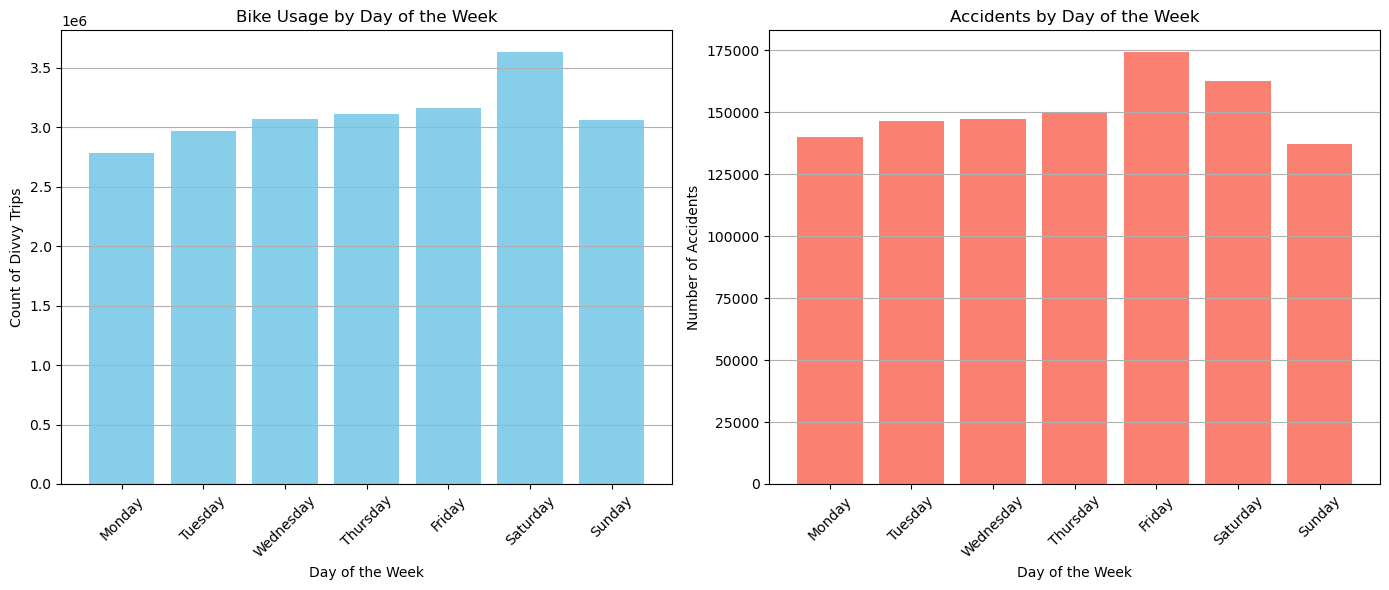

In [14]:

# order the days of the week for the plots
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
usage_by_day.index = pd.CategoricalIndex(usage_by_day.index, categories=day_order, ordered=True)
accidents_by_day.index = pd.CategoricalIndex(accidents_by_day.index, categories=day_order, ordered=True)
usage_by_day = usage_by_day.sort_index()
accidents_by_day = accidents_by_day.sort_index()

# Plotting bike usage and accidents by hour
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.bar(usage_by_day.index, usage_by_day.values, color='skyblue')
plt.title('Bike Usage by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count of Divvy Trips')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.subplot(1, 2, 2)
plt.bar(accidents_by_day.index, accidents_by_day.values, color='salmon')
plt.title('Accidents by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
# Save output
plt.savefig(os.path.join(save_dir, "Usage_Accidents_by_Day_of_Week.png"), dpi=300)

# Show plot
plt.show()
